# Import modelflow

In [132]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import modeljupyter as mj
from modelvis import waterplot


from modelclass import model
model.widescreen()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

# Load model and data, and run 

In [2]:
if not 'masia' in locals():
    print('Load model')
    masia,baseline = model.modelload('Asia.pcim',run=1,silent=1)

Load model


In [43]:
from inject import inject
inject(masia)

In [125]:
co2_input_var = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2')]

In [126]:
co2_baseline = baseline.loc[:,co2_input_var].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))

# Variables to inputwidget

In [4]:
outvar = 'GDI GCARBR CO2 LNN'.split()
displayvar = 'WLD_CO2 ASP_CO2 G20_CO2 '

#  masia.countries_GCARBR_A is list of all countries in the model with a countries_GCARBR_A 
#  masia.countries_ASEAN is list of all countries in ASEAN 
countries_rest = [country for country in masia.countries_GCARBR_A if country not in masia.countries_ASEAN]

slidedef_allasean =  {'All ASEAN countries' : {'var': ' '.join([f'{country}_GCARBR_A' for country in masia.countries_ASEAN ])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_allrest =  {'Rest of the world' : {'var': 
    ' '.join([f'{country}_GCARBR_A' for country in countries_rest])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_countries = {masia.iso_dict.get(country,country)+', Extra' : 
                      {'var': f'{country}_GCARBR_A', 'value': 0.0,'min':-40,'max':40,'op':'+impulse','step':10,'dec':0} 
                      for country in  masia.countries_ASEAN}

slidedef = {**slidedef_allasean,**slidedef_allrest,**slidedef_countries}

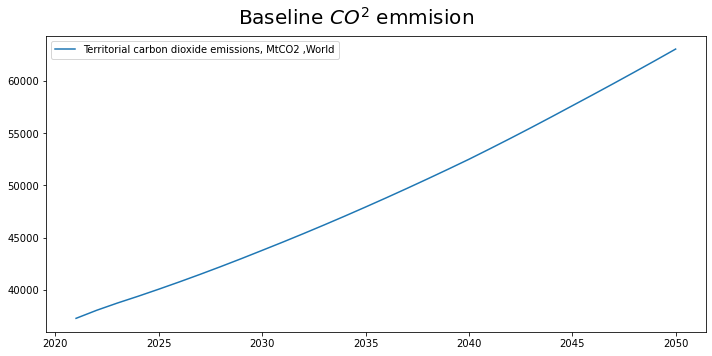

In [166]:
masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision',top=0.9,ysize=5);

# Emmision with no policy 

In [162]:
@interact(Threshold = (0,3000,100))
def explain(Periode   = Dropdown(options = masia.current_per,value=2050),
            Threshold =700):

    waterplot(co2_baseline.loc[[Periode],:].T,autosum=1,threshold = Threshold,allsort=1,title = 'CO2 emmision in',top=0.88);

interactive(children=(Dropdown(description='Periode', index=29, options=(2021, 2022, 2023, 2024, 2025, 2026, 2…

# Make some policy 

In [136]:
inject(masia)
input = masia.inputwidget_asia(2021,2050,slidedef=slidedef
                   ,showout=True,varpat=displayvar,showvar=True)

# Where does the reduction originate
The threshold leved and year can be chosen.
Countries where the reduction is below the threshold are all attributed to the "small" label  

In [131]:
@interact(Threshold = (0,300,10))
def explain(Periode   = Dropdown(options = masia.current_per,value=2050),
            Threshold =200):
    masia.dekomp_plot('WLD_CO2',pct=0,threshold=Threshold,nametrans=masia.nametrans)
    masia.dekomp_plot_per('WLD_CO2',pct=0,threshold=Threshold,per=Periode,sort=True,nametrans=masia.nametrans)


interactive(children=(Dropdown(description='Periode', index=29, options=(2021, 2022, 2023, 2024, 2025, 2026, 2…